# 目次（Table of Contents）
### [1. 全結合ニューラルネットワークでmnistのクラス分類](#1)
### [2. CNN(畳み込みニューラルネットワーク)でmnistのクラス分類](#2)
### [3. AutoEncoder](#3)
- [1次元データのautoencoder](#3-1)
- [エンコード表現にスパース制約を加えたautoencoder](#3-2)
- [Deep autoencoder(中間層を多層にしたautoencoder)](#3-3)
- [Convolutional autoencoder(画像データのautoencoder)](#3-4)
- [画像のノイズ除去への適用](#3-5)
- [Variational autoencoder(VAE)](#3-6)

参考にしたmarkdownのサイト<br>
[markdownの書き方1](https://qiita.com/higuma/items/3344387e0f2cce7f2cfe)<br>
[markdownの書き方2](https://qiita.com/iiokazuya/items/21ae40c1ee8ec9acd484)<br>
[jupyter notebook内のセルにリンクを貼る](https://qiita.com/shachah-svaahaa/items/b47a103ad38cca066e2e)

# 1. 全結合ニューラルネットワークでmnistのクラス分類<a id='1'></a>

[kerasでMNISTデータの学習を試してみよう](https://weblabo.oscasierra.net/python/keras-mnist-sample.html)を参考

In [14]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, InputLayer
from keras.optimizers import RMSprop

In [15]:
# MNISTデータを読み込む
# 0が白、255が黒
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# MNISTデータを加工する
print('reshape前 x_train.shape: {}'.format(x_train.shape))
x_train = x_train.reshape(60000, 784)
print('reshape後 x_train.shape: {}'.format(x_train.shape))
x_test = x_test.reshape(10000, 784)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

reshape前 x_train.shape: (60000, 28, 28)
reshape後 x_train.shape: (60000, 784)


In [16]:
# モデルの構築
model = Sequential()
model.add(InputLayer(input_shape=(784,)))
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_8 (Dense)              (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [17]:
# 学習
epochs = 40
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 2s 39us/step - loss: 0.6037 - acc: 0.8483 - val_loss: 0.3439 - val_acc: 0.9072
Epoch 2/40
60000/60000 [==============================] - 1s 24us/step - loss: 0.3307 - acc: 0.9083 - val_loss: 0.2999 - val_acc: 0.9168
Epoch 3/40
60000/60000 [==============================] - 1s 25us/step - loss: 0.3015 - acc: 0.9162 - val_loss: 0.2848 - val_acc: 0.9212
Epoch 4/40
60000/60000 [==============================] - 2s 26us/step - loss: 0.2881 - acc: 0.9200 - val_loss: 0.2816 - val_acc: 0.9225
Epoch 5/40
60000/60000 [==============================] - 1s 25us/step - loss: 0.2801 - acc: 0.9218 - val_loss: 0.2754 - val_acc: 0.9239
Epoch 6/40
60000/60000 [==============================] - 1s 24us/step - loss: 0.2745 - acc: 0.9240 - val_loss: 0.2715 - val_acc: 0.9254
Epoch 7/40
60000/60000 [==============================] - 1s 24us/step - loss: 0.2703 - acc: 0.9252 - val_loss: 0.2698 - val_acc

In [18]:
# 検証
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 0s 34us/step
Test loss: 0.27607525797784327
Test accuracy: 0.9291


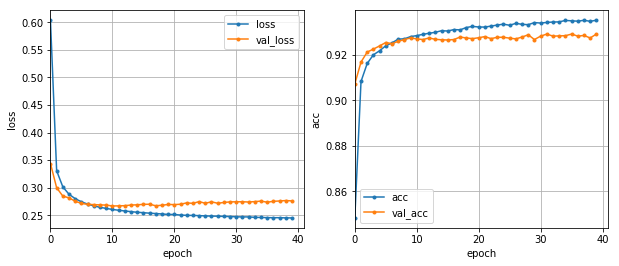

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(loss, marker='.', label='loss')
ax[0].plot(val_loss, marker='.', label='val_loss')
ax[0].legend(loc='best')
ax[0].grid(True)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_xlim(0)
ax[1].plot(acc, marker='.', label='acc')
ax[1].plot(val_acc, marker='.', label='val_acc')
ax[1].legend(loc='best')
ax[1].grid(True)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[1].set_xlim(0)
plt.show()

<a id='1-loss_acc_result'></a>
中間層が1層のモデルを40epoch回した結果<br>
val_accはepochが進むごとに若干向上しているが、val_lossは5epoch以降は下がっていないため、94%前後で飽和しそうである

# 2. CNN(畳み込みニューラルネットワーク)でmnistのクラス分類<a id='2'></a>

In [8]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, InputLayer, Flatten
from keras.optimizers import RMSprop

In [9]:
# MNISTデータを読み込む
# 0が白、255が黒
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# MNISTデータを加工する
print('reshape前 x_train.shape: {}'.format(x_train.shape))
x_train = x_train.reshape(60000, 28, 28, 1)
print('reshape後 x_train.shape: {}'.format(x_train.shape))
x_test = x_test.reshape(10000, 28, 28, 1)
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

reshape前 x_train.shape: (60000, 28, 28)
reshape後 x_train.shape: (60000, 28, 28, 1)


In [10]:
# CNNモデルの構築
model = Sequential()
model.add(InputLayer(input_shape=(28, 28, 1)))
model.add(Conv2D(filters=16, kernel_size=(3, 3), strides=(1, 1), padding='same'))
model.add(MaxPooling2D(pool_size=2, padding='same'))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 10)                31370     
Total params: 31,530
Trainable params: 31,530
Non-trainable params: 0
_________________________________________________________________


In [11]:
# 学習
epochs = 40
batch_size = 128
history = model.fit(x_train, y_train, batch_size=batch_size,
                    epochs=epochs, verbose=1, validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/40
60000/60000 [==============================] - 15s 244us/step - loss: 0.3901 - acc: 0.8951 - val_loss: 0.2368 - val_acc: 0.9335
Epoch 2/40
60000/60000 [==============================] - 13s 221us/step - loss: 0.2075 - acc: 0.9415 - val_loss: 0.1729 - val_acc: 0.9526
Epoch 3/40
60000/60000 [==============================] - 13s 217us/step - loss: 0.1505 - acc: 0.9586 - val_loss: 0.1343 - val_acc: 0.9616
Epoch 4/40
60000/60000 [==============================] - 13s 214us/step - loss: 0.1162 - acc: 0.9672 - val_loss: 0.1057 - val_acc: 0.9690
Epoch 5/40
60000/60000 [==============================] - 13s 218us/step - loss: 0.0963 - acc: 0.9730 - val_loss: 0.0913 - val_acc: 0.9730
Epoch 6/40
60000/60000 [==============================] - 13s 223us/step - loss: 0.0834 - acc: 0.9762 - val_loss: 0.0916 - val_acc: 0.9744
Epoch 7/40
60000/60000 [==============================] - 13s 222us/step - loss: 0.0751 - acc: 0.9786 - val_loss: 0.

In [12]:
# 検証
score = model.evaluate(x_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 73us/step
Test loss: 0.07817485016032005
Test accuracy: 0.9774


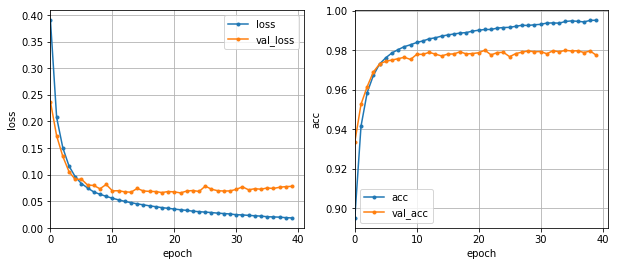

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
acc = history.history['acc']
val_acc = history.history['val_acc']

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(loss, marker='.', label='loss')
ax[0].plot(val_loss, marker='.', label='val_loss')
ax[0].legend(loc='best')
ax[0].grid(True)
ax[0].set_xlabel('epoch')
ax[0].set_ylabel('loss')
ax[0].set_xlim(0)
ax[1].plot(acc, marker='.', label='acc')
ax[1].plot(val_acc, marker='.', label='val_acc')
ax[1].legend(loc='best')
ax[1].grid(True)
ax[1].set_xlabel('epoch')
ax[1].set_ylabel('acc')
ax[1].set_xlim(0)
plt.show()

中間層が畳み込み層1、プーリング層1、全結合層が1のモデルを40epoch回したlossとaccuracyのグラフ<br>
グラフのlossが下がっているのに対して、validation_lossは飽和しつつある。accはepochが進むごとに上昇しているがval_lossが10epoch目で下がっていないためval_accは98%程度で飽和した。また、[1番目に行った実験](#1-loss_acc_result)との違いは畳み込み層の有無であるが、畳み込み層を加えるとval_accが4%程度上昇したことが分かった

# 3. AutoEncoder<a id='3'></a>
[keras公式のautoencoderのチュートリアル](https://blog.keras.io/building-autoencoders-in-keras.html)

## 1次元データのautoencoder<a id='3-1'></a>

In [18]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

In [19]:
# This model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [20]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train)), np.prod(x_train.shape[1:]))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print('x_train.shape: {}'.format(x_train.shape))
print('x_test.shape: {}'.format(x_test.shape))

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)


np.prod 配列の積　axis指定で指定の方向に掛け算される（listとtupleどちらもでも可能）

In [23]:
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test,x_test))

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 5s 83us/step - loss: 0.3591 - val_loss: 0.2705
Epoch 2/50
60000/60000 [==============================] - 4s 64us/step - loss: 0.2621 - val_loss: 0.2496
Epoch 3/50
60000/60000 [==============================] - 4s 66us/step - loss: 0.2399 - val_loss: 0.2281
Epoch 4/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.2214 - val_loss: 0.2121
Epoch 5/50
60000/60000 [==============================] - 4s 69us/step - loss: 0.2078 - val_loss: 0.2006
Epoch 6/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.1976 - val_loss: 0.1917
Epoch 7/50
60000/60000 [==============================] - 4s 68us/step - loss: 0.1896 - val_loss: 0.1847
Epoch 8/50
60000/60000 [==============================] - 6s 96us/step - loss: 0.1831 - val_loss: 0.1787
Epoch 9/50
60000/60000 [==============================] - 4s 7

In [42]:
# encode and decode some digits
# note that we take them from *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
print('encoded_imgs.mean(): {}'.format(encoded_imgs.mean()))
print('decoded_imgs.mean(): {}'.format(decoded_imgs.mean()))

encoded_imgs.mean(): 7.1941094398498535
decoded_imgs.mean(): 0.13335923850536346


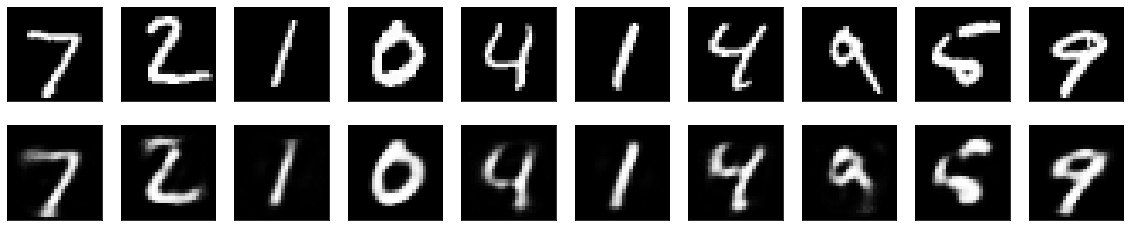

In [28]:
%matplotlib inline
# use Matplotlib(don't ask)
import matplotlib.pyplot as plt

n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstrution
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

※1次元データをreshapeで画像にして表示しています<br>
上の行が検証画像、下の行がautoencoderに検証画像を入力したときの出力画像<br>
すこしぼやけているが元の画像を正しく再現できていることがわかる

<a id='3-2'></a>
## Adding a sparsity constraint on the encoded representations<br>（エンコード表現にスパース制約を加えたautoencoder）
Adding a aparsity constraint(制約、強制) on the encoded representations<br>
In the previous example, the representations were only constrained by the size of the hidden layer (32). In such a situation, what typically happens is that the hidden layer is learning an approximation of PCA (principal component analysis). But another way to constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time. In Keras, this can be done by adding an activity_regularizer to our Dense layer:

In [1]:
from keras.layers import Input, Dense
from keras.models import Model
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(1e-6),
                )(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)

# This model maps an input to its encoded representation
encoder = Model(input_img, encoded)
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Using TensorFlow backend.


Instructions for updating:
Colocations handled automatically by placer.


In [2]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train)), np.prod(x_train.shape[1:]))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print('x_train.shape: {}'.format(x_train.shape))
print('x_test.shape: {}'.format(x_test.shape))

autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test,x_test))

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 4s 73us/step - loss: 0.3803 - val_loss: 0.2876
Epoch 2/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2811 - val_loss: 0.2730
Epoch 3/50
60000/60000 [==============================] - 3s 55us/step - loss: 0.2658 - val_loss: 0.2571
Epoch 4/50
60000/60000 [==============================] - 3s 54us/step - loss: 0.2502 - val_loss: 0.2410
Epoch 5/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.2354 - val_loss: 0.2274
Epoch 6/50
60000/60000 [==============================] - 3s 52us/step - loss: 0.2238 - val_loss: 0.2174
Epoch 7/50
60000/60000 [==============================] - 3s 53us/step - loss: 0.2151 - val_loss: 0.2100
Epoch 8/50
60000/60000 [==============================] - 3s 57us/step - loss: 0.2085 - val_loss: 0.2041
Epoch 9

訓練ロスは正則化項を加えてあるので検証ロスよりも大きくなっている（正則化によるロスは0.001ぐらい）

In [3]:
# encode and decode some digits
# note that we take them from *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
print('encoded_imgs.mean(): {}'.format(encoded_imgs.mean()))
print('decoded_imgs.mean(): {}'.format(decoded_imgs.mean()))

encoded_imgs.mean(): 1.8461776971817017
decoded_imgs.mean(): 0.1327461302280426


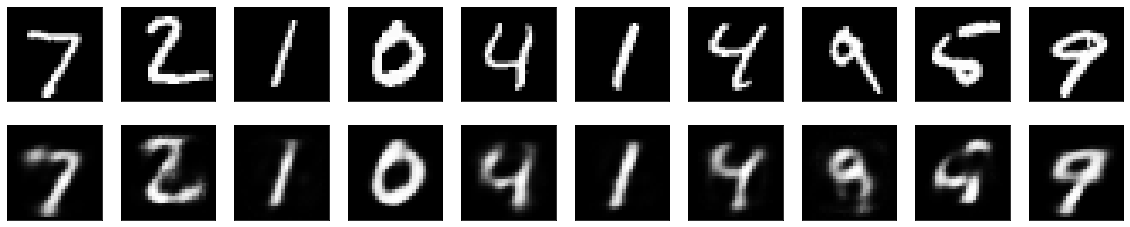

In [4]:
%matplotlib inline
# use Matplotlib(don't ask)
import matplotlib.pyplot as plt

n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))

for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstrution
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    #plt.imshow(autoencoder[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

検証画像をデコードした画像のencoded_img.mean()は、正則化なしは7.19、正則化ありは1.85となり正則化を加えた方が小さくなっていることが確認できた。これより、正則化によって重みがスパースになっていることが分かった。<br>
また、デコードした画像は（下の行の数字画像）正則化なしに比べて全体的にぼやけている印象を受けるが、正しく再現できていることが分かった

<a id='3-3'></a>
## Deep autoencoder(中間層を多層にしたautoencoder)
We do not have to limit ourselves to a single layer as encoder or decoder, we could instead use a stack of layers, such as:<br>
層をスタック状にしたautoencoder<br>
[stack autoencoderのdecoderの作り方](https://stackoverflow.com/questions/44472693/how-to-decode-encoded-data-from-deep-autoencoder-in-keras-unclarity-in-tutorial)

In [23]:
from keras.layers import Input, Dense
from keras.models import Model
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train)), np.prod(x_train.shape[1:]))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print('x_train.shape: {}'.format(x_train.shape))
print('x_test.shape: {}'.format(x_test.shape))

input_img = Input(shape=(784,))
encoded = Dense(128, activation='relu')(input_img)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(encoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = Dense(784, activation='sigmoid')(decoded)

autoencoder = Model(input_img, decoded)

encoder = Model(input_img, encoded)
encoded_input = Input(shape=(32,))

decoded = autoencoder.layers[-3](encoded_input)
decoded = autoencoder.layers[-2](decoded)
decoded = autoencoder.layers[-1](decoded)
decoder = Model(encoded_input, decoded)

autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

autoencoder.fit(x_train, x_train,
                epochs=100,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

x_train.shape: (60000, 784)
x_test.shape: (10000, 784)
Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 10s 168us/step - loss: 0.3489 - val_loss: 0.2640
Epoch 2/100
60000/60000 [==============================] - 6s 94us/step - loss: 0.2549 - val_loss: 0.2444 ETA: 1s -  - ETA: 0s 
Epoch 3/100
60000/60000 [==============================] - 5s 90us/step - loss: 0.2309 - val_loss: 0.2167
Epoch 4/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.2128 - val_loss: 0.2082
Epoch 5/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.2034 - val_loss: 0.1981
Epoch 6/100
60000/60000 [==============================] - 6s 93us/step - loss: 0.1964 - val_loss: 0.1936
Epoch 7/100
60000/60000 [==============================] - 6s 92us/step - loss: 0.1911 - val_loss: 0.1869
Epoch 8/100
60000/60000 [==============================] - 6s 92us/step - loss: 0

In [26]:
# encode and decode some digits
# note that we take them from *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)
print('encoded_imgs.mean(): {}'.format(encoded_imgs.mean()))
print('decoded_imgs.mean(): {}'.format(decoded_imgs.mean()))

encoded_imgs.mean(): 5.320903301239014
decoded_imgs.mean(): 0.12784786522388458


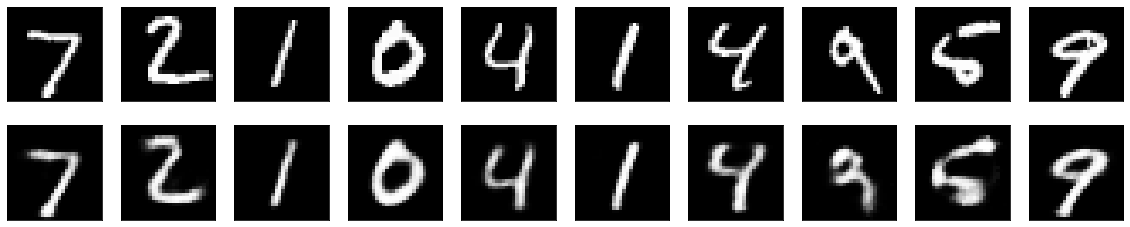

In [27]:
%matplotlib inline
# use Matplotlib(don't ask)
import matplotlib.pyplot as plt

n = 10 # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstrution
    ax = plt.subplot(2, n, i + 1+ n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

※1次元データをreshapeで画像にして表示しています<br>簡単な画像なので、stackにした良さがあまり分からないが、正しくデコードできていることが分かる

<a id='3-4'></a>
## Convolutional autoencoder(画像データのautoencoder)
Since our inputs are images, it makes sense to use convolutional neural networks (convnets) as encoders and decoders. In practical settings, autoencoders applied to images are always convolutional autoencoders --they simply perform much better.

Let's implement one. The encoder will consist in a stack of Conv2D and MaxPooling2D layers (max pooling being used for spatial down-sampling), while the decoder will consist in a stack of Conv2D and UpSampling2D layers.

In [35]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(28, 28, 1))
x = Conv2D(16, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (4, 4, 8) i.e. 128-dimensional
x = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(8, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(16, (3, 3), activation='relu')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [63]:
print(input_img)
encoder = Model(input_img, encoded)
#print(encoder.layers[-1])
#encoded_input = Input(shape=(32,))

#decoded = autoencoder.layers[-3](encoded_input)
#decoded = autoencoder.layers[-2](decoded)
#decoded = autoencoder.layers[-1](decoded)
#decoder = Model(encoded_input, decoded)

Tensor("input_54:0", shape=(?, 28, 28, 1), dtype=float32)


To train it, we will use the original MNIST digits with shape (samples, 3, 28, 28), and we will just normalize pixel values between 0 and 1.

In [64]:
from keras.datasets import mnist
import numpy as np

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))  # adapt this if using `channels_first` image data format
Let's train this model for 50 epochs. For the sake of demonstrating how to visualize the results of a model during training, we will be using the TensorFlow backend and the TensorBoard callback.

First, let's open up a terminal and start a TensorBoard server that will read logs stored at /tmp/autoencoder.

In [39]:
from keras.callbacks import TensorBoard

history = autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test),
                )

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 78s 1ms/step - loss: 0.2220 - val_loss: 0.1820
Epoch 2/50
60000/60000 [==============================] - 67s 1ms/step - loss: 0.1605 - val_loss: 0.1511
Epoch 3/50
60000/60000 [==============================] - 67s 1ms/step - loss: 0.1433 - val_loss: 0.1319
Epoch 4/50
60000/60000 [==============================] - 67s 1ms/step - loss: 0.1344 - val_loss: 0.1288
Epoch 5/50
60000/60000 [==============================] - 67s 1ms/step - loss: 0.1292 - val_loss: 0.1254
Epoch 6/50
60000/60000 [==============================] - 66s 1ms/step - loss: 0.1256 - val_loss: 0.1247
Epoch 7/50
60000/60000 [==============================] - 66s 1ms/step - loss: 0.1226 - val_loss: 0.1220
Epoch 8/50
60000/60000 [==============================] - 66s 1ms/step - loss: 0.1200 - val_loss: 0.1232
Epoch 9/50
60000/60000 [==============================] - 68s 1ms/step - loss: 0.1183 - val_loss: 0.1157
Epoch

(10000, 28, 28, 1)


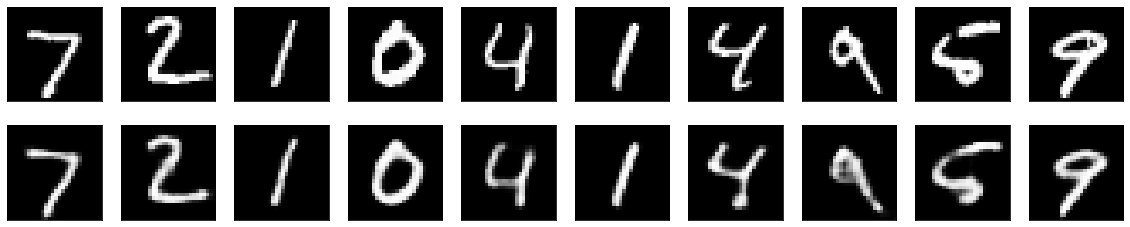

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test)
print(decoded_imgs.shape)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

We can also have a look at the 128-dimensional encoded representations. These representations are 8x4x4, so we reshape them to 4x32 in order to be able to display them as grayscale images.<br>
畳み込み層を用いることによって画像をデコードすることが可能になった<br>
mnistに関しては、良く再現できていることが分かる

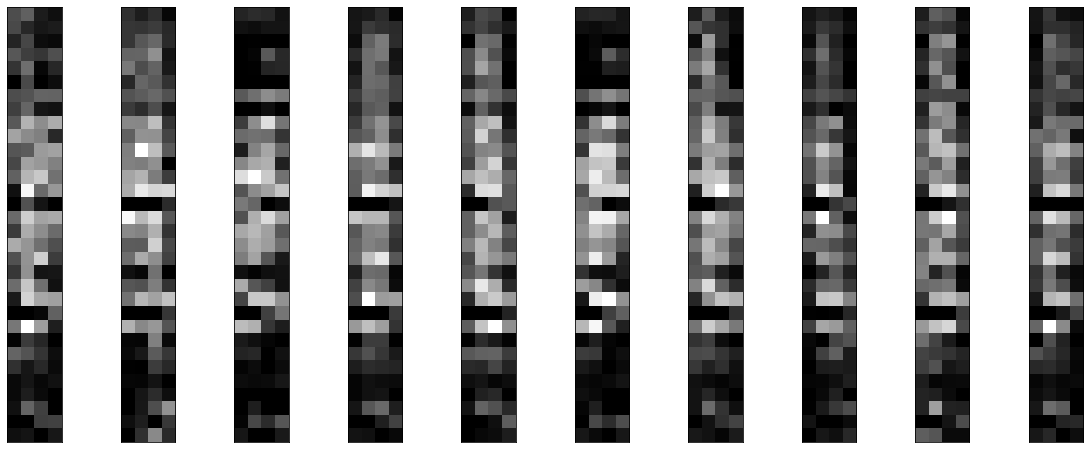

In [68]:
n = 10
plt.figure(figsize=(20, 8))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(encoded_imgs[i].reshape(4, 4*8).T)
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Convolitional autoencoderのエンコード画像が上の10個のマップである。mnistがほとんど画像の中心に数字が書かれていることが多いため、画像をエンコードしたとき上のような真ん中の方に特徴が多く分布しているのではないかと考察した

<a id='3-5'></a>
## Application to image denoising（画像のノイズ除去への適用）
Let's put our convolutional autoencoder to work on an image denoising problem. It's simple: we will train the autoencoder to map noisy digits images to clean digits images.

Here's how we will generate synthetic noisy digits: we just apply a gaussian noise matrix and clip the images between 0 and 1.

In [6]:
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

(x_train, _), (x_test, _) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

noise_factor = 0.5
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

np.clip<br>
第一引数aに処理する配列ndarray、第二引数a_minに最小値、第三引数a_maxに最大値

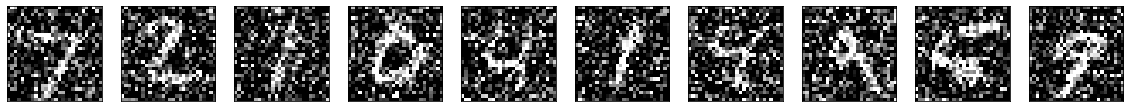

In [13]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

If you squint you can still recognize them, but barely. Can our autoencoder learn to recover the original digits? Let's find out.

Compared to the previous convolutional autoencoder, in order to improve the quality of the reconstructed, we'll use a slightly different model with more filters per layer:<br>
以前のモデルよりもフィルターを増やす

In [8]:
input_img = Input(shape=(28, 28, 1))
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)

# at this point the representation is (7, 7, 32)

x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

Instructions for updating:
Colocations handled automatically by placer.


In [9]:
history = autoencoder.fit(x_train_noisy, x_train,
                          epochs=30,
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test),
                          )

Instructions for updating:
Use tf.cast instead.
Train on 60000 samples, validate on 10000 samples
Epoch 1/30
60000/60000 [==============================] - 144s 2ms/step - loss: 0.1765 - val_loss: 0.1251
Epoch 2/30
60000/60000 [==============================] - 135s 2ms/step - loss: 0.1184 - val_loss: 0.1162
Epoch 3/30
60000/60000 [==============================] - 139s 2ms/step - loss: 0.1113 - val_loss: 0.1098
Epoch 4/30
60000/60000 [==============================] - 149s 2ms/step - loss: 0.1078 - val_loss: 0.1054
Epoch 5/30
60000/60000 [==============================] - 144s 2ms/step - loss: 0.1056 - val_loss: 0.1043
Epoch 6/30
60000/60000 [==============================] - 144s 2ms/step - loss: 0.1040 - val_loss: 0.1013
Epoch 7/30
60000/60000 [==============================] - 144s 2ms/step - loss: 0.1030 - val_loss: 0.1023
Epoch 8/30
60000/60000 [==============================] - 143s 2ms/step - loss: 0.1022 - val_loss: 0.0998
Epoch 9/30
60000/60000 [==============================

(10000, 28, 28, 1)


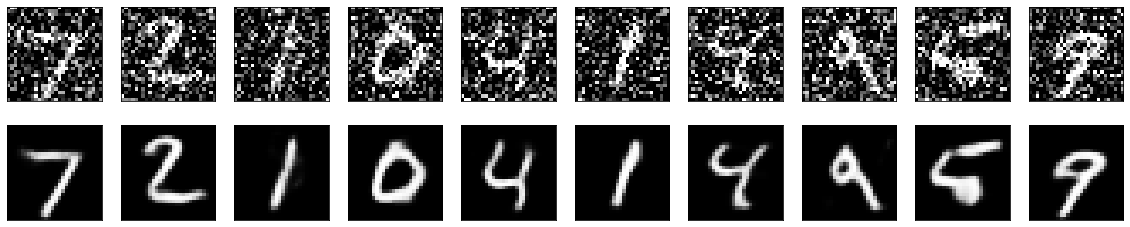

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt

decoded_imgs = autoencoder.predict(x_test_noisy)
print(decoded_imgs.shape)

n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(x_test_noisy[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
    # display reconstruction
    ax = plt.subplot(2, n, i + n + 1)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

上の行がノイズを乗せた検証画像で、下の行が検証画像を入力したときのautoencoderの出力画像<br>
綺麗にノイズ除去できていることが確認できた！

<a id='3-6'></a>
## Variational autoencoder (VAE)　変分オートエンコーダ
Variational autoencoders are a slightly more modern and interesting take on autoencoding.

What is a variational autoencoder, you ask? It's a type of autoencoder with added constraints on the encoded representations being learned. More precisely, it is an autoencoder that learns a latent variable model for its input data. So instead of letting your neural network learn an arbitrary function, you are learning the parameters of a probability distribution modeling your data. If you sample points from this distribution, you can generate new input data samples: a VAE is a "generative model".

How does a variational autoencoder work?

First, an encoder network turns the input samples x into two parameters in a latent space, which we will note z_mean and z_log_sigma. Then, we randomly sample similar points z from the latent normal distribution that is assumed to generate the data, via z = z_mean + exp(z_log_sigma) * epsilon, where epsilon is a random normal tensor. Finally, a decoder network maps these latent space points back to the original input data.

The parameters of the model are trained via two loss functions: a reconstruction loss forcing the decoded samples to match the initial inputs (just like in our previous autoencoders), and the KL divergence between the learned latent distribution and the prior distribution, acting as a regularization term. You could actually get rid of this latter term entirely, although it does help in learning well-formed latent spaces and reducing overfitting to the training data.

Because a VAE is a more complex example, we have made the code available on Github as a standalone script. Here we will review step by step how the model is created.

First, here's our encoder network, mapping inputs to our latent distribution parameters:

[KLダイバージェンスとは](https://qiita.com/ceptree/items/9a473b5163d5655420e8)<br>
Kullback-Leibler divergenceは、２つの確率分布がどの程度似ているかを示す尺度のこと<br>
特性１　同じ確率分布では0になる<br>
特性２　常に0を含む正の値となり、確率分布が似ていないほど、大きな値となる

[VAEを詳細に書いているサイト](http://cympfh.cc/paper/VAE.html)<br>
[最新のkeras公式のVAEの実装サイト（下のソースコードはこれを写経したもの）](https://github.com/keras-team/keras/blob/master/examples/variational_autoencoder.py)<br><br>
[keras公式のkeras.backendのところ](https://keras.io/backend/)<br>
[Jupyter lab / notebookで argparseそのままで実行する方法](https://qiita.com/uenonuenon/items/09fa620426b4c5d4acf9)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 784)          0                                            
__________________________________________________________________________________________________
dense_4 (Dense)                 (None, 512)          401920      encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_4[0][0]                    
__________________________________________________________________________________________________
z (Lambda)

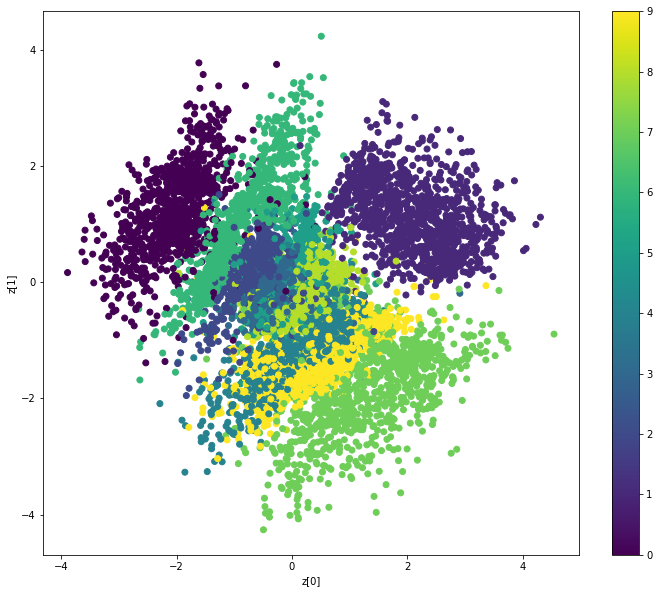

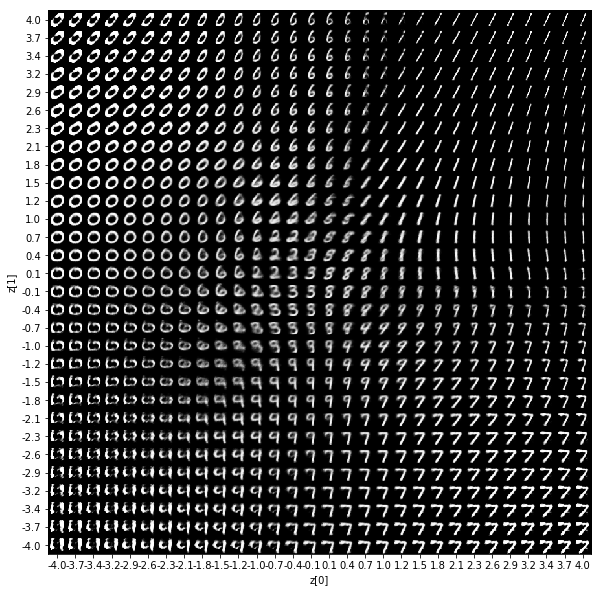

In [2]:
# KerasのVAEを写経し実行
from keras.layers import Lambda, Input, Dense
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os


# reparameterization trick
# instead of sampling from Q(z|X), sample epsilon = N(0,I)
# z = z_mean + sqrt(var) * epsilon
def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


def plot_results(models,
                 data,
                 batch_size=128,
                 model_name="vae_mnist"):
    """Plots labels and MNIST digits as a function of the 2D latent vector
    # Arguments
        models (tuple): encoder and decoder models
        data (tuple): test data and label
        batch_size (int): prediction batch size
        model_name (string): which model is using this function
    """

    encoder, decoder = models
    x_test, y_test = data
    # os.makedirsは中間ディレクトリも一緒に作ってくれる os.mkdirではできない
    # exist_ok=Trueのとき、末端ディレクトリがなかったら新規作成、あったらスルーする
    os.makedirs(model_name, exist_ok=True)

    filename = os.path.join(model_name, "vae_mean.png")
    # display a 2D plot of the digit classes in the latent space
    # encoder.predictはz_mean、z_log_var, zの2次元の値を返す？
    z_mean, _, _ = encoder.predict(x_test,
                                   batch_size=batch_size)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=y_test) # c: 色、または、連続した色の値(今回は０～９の離散値）
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.savefig(filename)
    plt.show()

    filename = os.path.join(model_name, "digits_over_latent.png")
    # display a 30x30 2D manifold of digits
    n = 30
    digit_size = 28
    figure = np.zeros((digit_size * n, digit_size * n))
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-4, 4, n)
    grid_y = np.linspace(-4, 4, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = decoder.predict(z_sample)
            digit = x_decoded[0].reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

    plt.figure(figsize=(10, 10))
    start_range = digit_size // 2
    end_range = (n - 1) * digit_size + start_range + 1
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='Greys_r')
    plt.savefig(filename)
    plt.show()


# MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

image_size = x_train.shape[1]
original_dim = image_size * image_size
x_train = np.reshape(x_train, [-1, original_dim]) # reshapeの-1は周りから推論してくれる
x_test = np.reshape(x_test, [-1, original_dim])
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# network parameters
input_shape = (original_dim, )
intermediate_dim = 512
batch_size = 128
latent_dim = 2
epochs = 50

# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = Dense(intermediate_dim, activation='relu')(inputs)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder,
           to_file='vae_mlp_encoder.png',
           show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(intermediate_dim, activation='relu')(latent_inputs)
outputs = Dense(original_dim, activation='sigmoid')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, 
           to_file='vae_mlp_decoder.png',
           show_shapes=True)

# instantiate VAE model
# outputs: encoderの出力とdecoderの入力を接続
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae_mlp')

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    help_ = "Load h5 model trained weights"
    parser.add_argument("-w", "--weights", help=help_)
    help_ = "Use mse loss instead of binary cross entropy (default)"
    parser.add_argument("-m",
                        "--mse",
                        help=help_, action='store_true')
    # jupyter notebook上で引数を与えたいときargs = parser.parse_args(args=[])とすればよい
    # (ちなみに、args=[]は引数を何も与えていない状態)
    args = parser.parse_args(args=[])
    models = (encoder, decoder)
    data = (x_test, y_test)

    # VAE loss = mse_loss or xent_loss + kl_loss
    if args.mse:
        reconstruction_loss = mse(inputs, outputs)
    else:
        reconstruction_loss = binary_crossentropy(inputs,
                                                  outputs)

    reconstruction_loss *= original_dim
    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
    kl_loss = K.sum(kl_loss, axis=-1)
    kl_loss *= -0.5
    vae_loss = K.mean(reconstruction_loss + kl_loss)
    vae.add_loss(vae_loss) # vaeに自作lossを追加
    vae.compile(optimizer='adam')
    vae.summary()
    plot_model(vae,
               to_file='vae_mlp.png',
               show_shapes=True)

    if args.weights:
        vae.load_weights(args.weights)
    else:
        # train the autoencoder
        vae.fit(x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=(x_test, None))
        #vae.save_weights('vae_mlp_mnist.h5')

    plot_results(models,
                 data,
                 batch_size=batch_size,
                 model_name="vae_mlp")

正規分布(おそらく)で学習させているため、上の図はz[0], z[1]の0付近を中心に各データ点が分布しているように見える<br>
また下図から、上図の各クラスのデータ分布と潜在変数z[0],z[1]座標の値からデコードした画像は上のクラス分布とほぼ一致していることが分かった。<br>VAEは、任意の潜在変数から新たに好きな画像を生成することが可能なGenerative modelであることを確認した。